## Loading data

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import json

import datetime as dt
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.utils import resample
from sklearn import svm

In [2]:
conn = sqlite3.connect('sqlite.db')
df_exec = pd.read_sql_query("SELECT * FROM 'exec';", conn)

In [3]:
display(df_exec.head())

,ts,exe,pid,ppid,path,docker,depth,rates
0,0.690,sh,28531,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.2}"
1,0.696,lpstat,28532,28531,/usr/bin/lpstat,None,-1,"{""1"": 2.0, ""5"": 0.4}"
2,0.701,sed,28533,28531,/bin/sed,None,-1,"{""1"": 3.0, ""5"": 0.6}"
3,1.704,sh,28534,1158,/bin/sh,None,-1,"{""1"": 1.0, ""5"": 0.8}"
4,1.711,sed,28536,28534,sed,None,-1,"{""1"": 2.0, ""5"": 1.0}"


In [4]:
df_exec['rates1'] = np.nan
df_exec['rates5'] = np.nan
for it in enumerate(df_exec.rates.values):
    Dic = json.loads((it[1]))
    df_exec.set_value(it[0], 'rates1', Dic["1"])
    df_exec.set_value(it[0], 'rates5', Dic["5"])
    
df_exec = df_exec.sort_values('ts').reset_index(drop=True)    
   

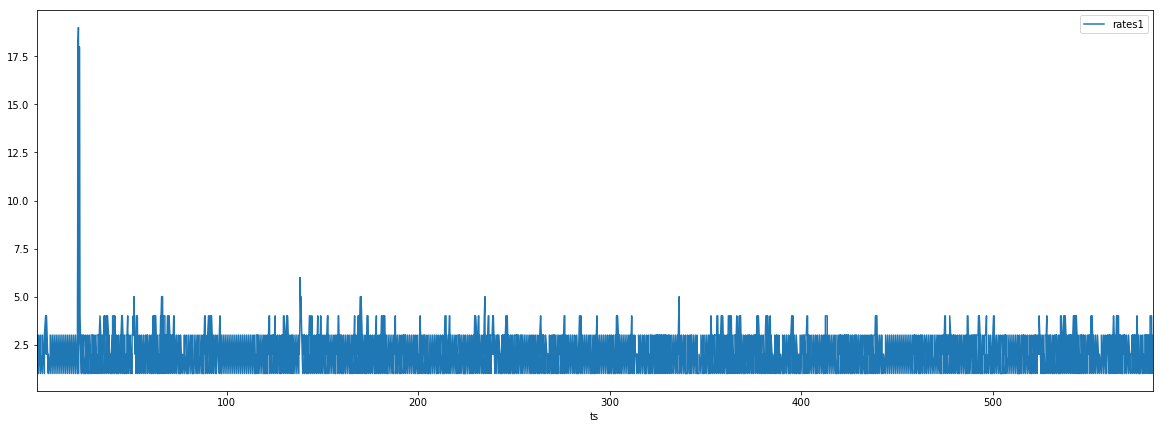

In [5]:
tm = df_exec[['ts','rates1']].set_index('ts')
tm.plot(figsize=(20,7))
plt.show()

## Data Statistics

In [6]:
conn = sqlite3.connect('sqlite.db')
df_tcplife = pd.read_sql_query("SELECT * FROM 'tcplife';", conn)

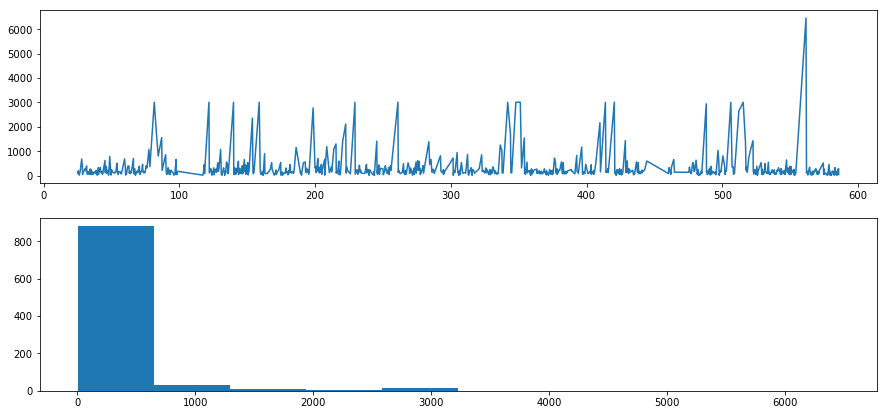

,ts,pid,rx,tx,dur,prediction,predquality
count,944.000000,944.000000,944.000000,944.0,944.000000,944.000000,944.000000
mean,307.715209,29928.452331,61.332627,0.0,261.219121,-15.492141,0.875000
std,171.971029,751.111665,69.228605,0.0,479.331879,23.434887,0.330894
min,25.147065,28668.000000,0.000000,0.0,5.040000,-569.245187,0.000000
25%,157.886505,29267.750000,4.000000,0.0,85.512500,-13.940197,1.000000
50%,307.397860,29935.500000,26.000000,0.0,144.650000,-11.497844,1.000000
75%,462.115531,30601.000000,115.000000,0.0,226.797500,-10.481379,1.000000
max,585.672974,31149.000000,540.000000,0.0,6454.020000,8.375431,1.000000


In [7]:
f, (ax1, ax2) = plt.subplots(2, 1,figsize=(15,7))
ax1.plot(df_tcplife.ts,df_tcplife.dur)
ax2.hist(df_tcplife.dur,bins = 10)
plt.show()

df_tcplife.describe()

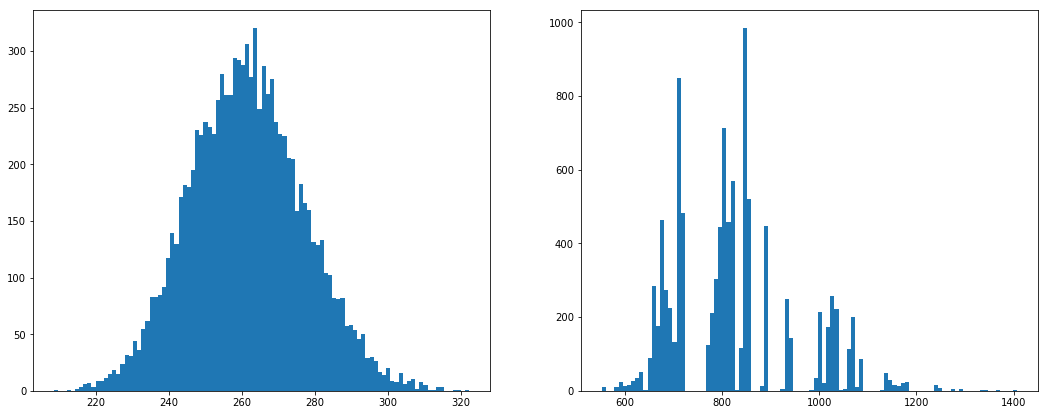

In [11]:
np.percentile(np.array(df_tcplife.dur),99)

#use bootstrapping to approximate the real distribution of "dur"
bootstrapping_dist = np.zeros(10000)
tile_dist = np.zeros(10000)
for i in range(10000):
    X = resample(np.array(df_tcplife.dur), replace=True)
    bootstrapping_dist[i] = np.mean(X)
    tile_dist[i] = np.percentile(X,95)
    

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,7)) 
ax1.hist(bootstrapping_dist,bins=100)
#ax1.title('bootstrapping of mean')
ax2.hist(tile_dist,bins=100)
#ax2.title('bootstrapping of 99-percentile')
plt.show()

In [12]:
#get the indexes of outliers
thres = np.percentile(tile_dist,95)
df_outliers = df_tcplife.loc[df_tcplife['dur']>thres]

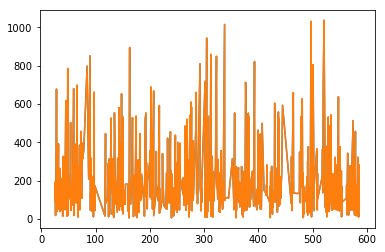

In [17]:
df_tcplife.loc[(df_tcplife['dur']<thres)].shape
plt.plot(df_tcplife.loc[(df_tcplife['dur']<thres)].ts,df_tcplife.loc[(df_tcplife['dur']<thres)].dur)
plt.show()

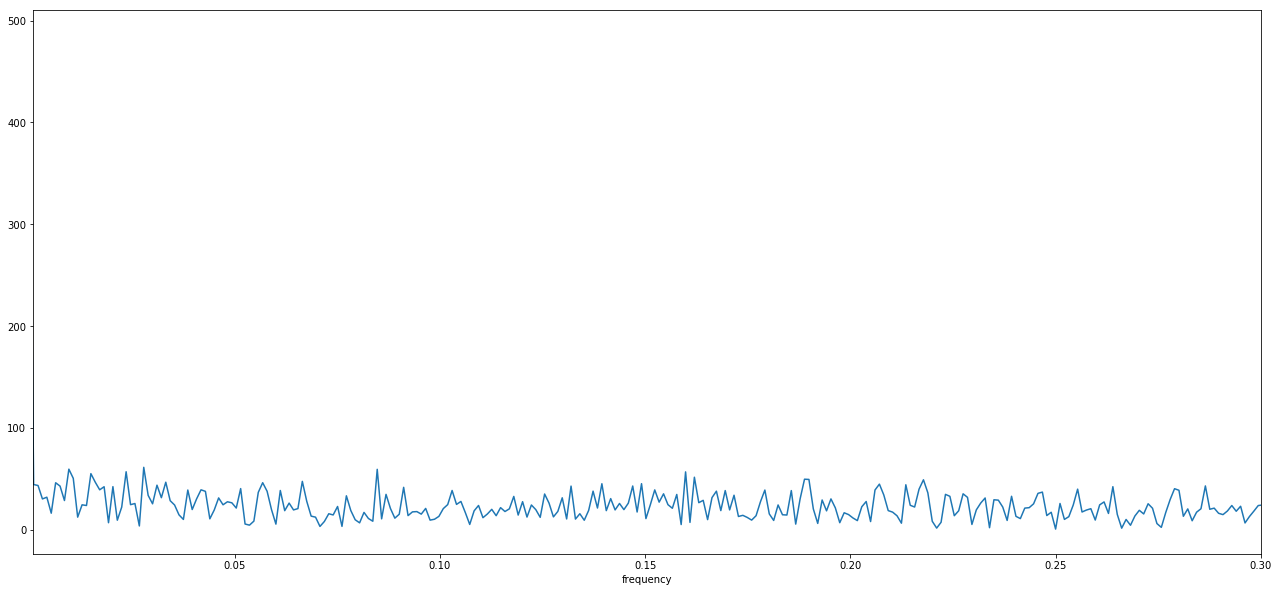

In [104]:
def freq_ana(series,plotting = False):
        #print(series)
        fs = series.shape[0]/np.ptp(series.index.values)
        fs_ = str(fs)

        y = series['dur']

        yf = np.fft.fft(y)
        xf = np.linspace(0.0, 1.0/(2.0*fs), len(y)/2)
        f = 2.0/len(y) * np.abs(yf[:len(y)//2])
        if plotting:
            fig, ax = plt.subplots(figsize = (22,10))
            ax.plot(xf, 2.0/len(y) * np.abs(yf[:len(y)//2]))
            ax.set_xlim(0.001, 0.3)
            plt.xlabel('frequency')
            #plt.title('freq analysis of weekdays data')\n",
            plt.show()
        return xf,f
    
xf,f = freq_ana(df_tcplife.loc[(df_tcplife['dur']<thres)][['dur','ts']],plotting = True)

## Data Modeling

In [ ]:
#X = df_tcplife.ts.values
#y = df_tcplife.dur.values

#clf = svm.SVR()
#clf.fit(X, y)
from pandas.tools.plotting import autocorrelation_plot

plt.figure(figsize=(20,8))
autocorrelation_plot(df_tcplife.dur.values)
plt.show()

[  4.93623518e+02   4.45068417e+02   3.99505444e+02   3.56920903e+02
   3.17313892e+02   2.80699842e+02   2.47114979e+02   2.16621548e+02
   1.89312929e+02   1.65316080e+02   1.44785576e+02   1.27878933e+02
   1.14700845e+02   1.05214797e+02   9.91533997e+01   9.59916602e+01
   9.50248373e+01   9.55135979e+01   9.68150356e+01   9.84532178e+01
   1.00136405e+02   1.01748163e+02   1.03332766e+02   1.05082570e+02
   1.07325283e+02   1.10503161e+02   1.15134699e+02   1.21755388e+02
   1.30847644e+02   1.42782779e+02   1.57796141e+02   1.75998996e+02
   1.97412882e+02   2.22007755e+02   2.49732237e+02   2.80532914e+02
   3.14364542e+02   3.51194284e+02   3.91002600e+02   4.33782521e+02
   4.79538273e+02   5.28283778e+02   5.80041233e+02   6.34839876e+02
   6.92714939e+02   7.53706775e+02   8.17860141e+02   8.85223608e+02
   9.55849064e+02   1.02979131e+03   1.10710770e+03   1.18785788e+03
   1.27210351e+03   1.35990802e+03   1.45133649e+03   1.54645542e+03
   1.64533258e+03   1.74803692e+03

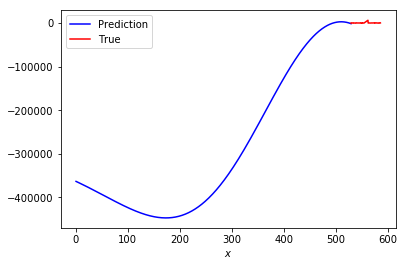

In [123]:
from sklearn.gaussian_process import GaussianProcess

# now the noisy case
X = np.array(df_tcplife.ts.values[750:800])
X = np.atleast_2d(X).T

# Observations and noise
y = np.array(df_tcplife.dur.values[750:800])


# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(df_tcplife.ts.values[801], 0.5, df_tcplife.ts.values[943])).T
x_ = np.atleast_2d(np.array(df_tcplife.ts.values[801:943])).T
y_ = np.atleast_2d(np.array(df_tcplife.dur.values[801:943])).T
# Instanciate a Gaussian Process model
gp = GaussianProcess(corr='squared_exponential', theta0=1e-1,
                     thetaL=1e-3, thetaU=1,
                     nugget=(dy / y) ** 2,
                     random_start=100)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, MSE = gp.predict(x, eval_MSE=True)
sigma = np.sqrt(MSE)
print(sigma)
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
#plt.plot(X, y, 'r:')
#plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.plot(x_, y_, 'r-', label=u'True')
#plt.fill(np.concatenate([x, x[::-1]]),
#        np.concatenate([y_pred - 1.9600 * sigma,
#                       (y_pred + 1.9600 * sigma)[::-1]]),
#        alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
#plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()

In [127]:
display(df_tcplife.loc[500:600])

,ts,pid,lport,rport,rx,tx,dur,histotimes,histosizes,histoports,docker,prediction,predquality
500,328.614010,30022,48052,80,40,0,89.28,"[[462, 24, 6, 2, 7], 5.04, 3006.16]","[[295, 181, 21, 3, 1], 0, 427]","[[""22"", ""80"", ""443"", ""other""], {""443"": 55, ""80...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.032227,1
501,328.878651,30026,48054,80,147,0,241.97,"[[463, 24, 6, 2, 7], 5.04, 3006.16]","[[295, 182, 21, 3, 1], 0, 427]","[[""22"", ""80"", ""443"", ""other""], {""443"": 55, ""80...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-13.456307,1
502,329.287762,30027,40152,80,5,0,34.43,"[[464, 24, 6, 2, 7], 5.04, 3006.16]","[[296, 182, 21, 3, 1], 0, 427]","[[""22"", ""80"", ""443"", ""other""], {""443"": 55, ""80...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.621913,1
503,330.031723,30028,37918,80,26,0,215.21,"[[465, 24, 6, 2, 7], 5.04, 3006.16]","[[297, 182, 21, 3, 1], 0, 427]","[[""22"", ""80"", ""443"", ""other""], {""443"": 55, ""80...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.437365,1
504,330.285154,30032,48060,80,89,0,92.09,"[[466, 24, 6, 2, 7], 5.04, 3006.16]","[[297, 183, 21, 3, 1], 0, 427]","[[""22"", ""80"", ""443"", ""other""], {""443"": 55, ""80...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.999897,1
505,330.979028,30033,46836,80,84,0,355.99,"[[467, 24, 6, 2, 7], 5.04, 3006.16]","[[298, 183, 21, 3, 1], 0, 427]","[[""22"", ""80"", ""443"", ""other""], {""443"": 55, ""80...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-10.993300,1
506,331.628868,30038,48064,80,124,0,240.90,"[[468, 24, 6, 2, 7], 5.04, 3006.16]","[[298, 184, 21, 3, 1], 0, 427]","[[""22"", ""80"", ""443"", ""other""], {""443"": 55, ""80...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-12.229674,1
507,332.318490,30042,60964,80,2,0,74.30,"[[469, 24, 6, 2, 7], 5.04, 3006.16]","[[299, 184, 21, 3, 1], 0, 427]","[[""22"", ""80"", ""443"", ""other""], {""443"": 55, ""80...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-11.656683,1
508,332.675045,30043,48068,80,161,0,195.17,"[[470, 24, 6, 2, 7], 5.04, 3006.16]","[[299, 185, 21, 3, 1], 0, 427]","[[""22"", ""80"", ""443"", ""other""], {""443"": 55, ""80...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-14.304496,1
509,332.992403,30047,48070,80,110,0,156.15,"[[471, 24, 6, 2, 7], 5.04, 3006.16]","[[299, 186, 21, 3, 1], 0, 427]","[[""22"", ""80"", ""443"", ""other""], {""443"": 55, ""80...",/docker/6aebd9a7d81f55435baff1afbcc16b11362669...,-11.618142,1


In [19]:
from sklearn.svm import SVR

def predict(dates, prices, x):
	dates = np.reshape(dates,(len(dates), 1)) # converting to matrix of n X 1

	
	#svr_poly = SVR(kernel= 'poly', C= 1e3, degree= 2)
	svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1) # defining the support vector regression models
	svr_rbf.fit(dates, prices) # fitting the data points in the models
	#svr_lin.fit(dates, prices)
	#svr_poly.fit(dates, prices)

	plt.scatter(dates, prices, color= 'black', label= 'Data') # plotting the initial datapoints 
	plt.plot(dates, svr_rbf.predict(dates), color= 'red', label= 'RBF model') # plotting the line made by the RBF kernel
	#plt.plot(dates,svr_lin.predict(dates), color= 'green', label= 'Linear model') # plotting the line made by linear kernel
	#plt.plot(dates,svr_poly.predict(dates), color= 'blue', label= 'Polynomial model') # plotting the line made by polynomial kernel
	plt.xlabel('ts')
	plt.ylabel('dur')
	plt.title('Support Vector Regression')
	plt.legend()
	plt.show()

	return svr_rbf.predict(x)#, svr_lin.predict(x)[0], svr_poly.predict(x)[0]

#predicted_price = predict(df_tcplife.ts.values, df_tcplife.dur.values, 600)  

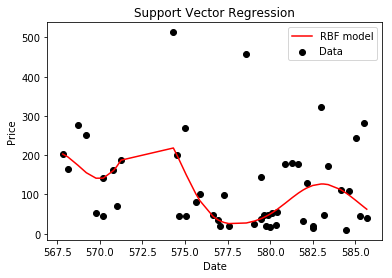

In [26]:
T = np.ptp(df_tcplife.ts.values)/df_tcplife.shape[0]

last_ts = df_tcplife.ts.values[-1]

X_test = np.linspace(last_ts, T*25+last_ts, num=25)
#using the last 50 data points to predict
predicted = predict(df_tcplife.ts.values[-50:], df_tcplife.dur.values[-50:], np.atleast_2d(X_test).T) 

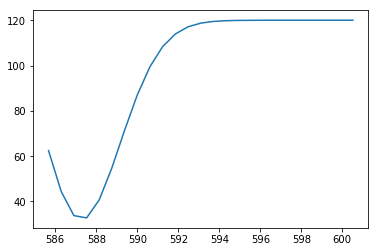

In [27]:
plt.plot(X_test,predicted)
plt.show()